# Travail du modèle

Dans cette section, on va standardiser les données pour les préparer au SMOTE, puis on va tester plusieurs méthodes de régressions pour sélectionner le meilleure modèle. Après, On affichera les données avec un Dashboard avec un API

## Sommaire :

* [Travail du modèle](#chapter1)
    * [Standaridisation](#section_1_1)
* [Smote](#chapter2)
    * [DummyClassifier](#section_2_1)
    * [RandomForest](#section_2_2)
    * [LGBMClassifier](#section_2_3)
    * [XGBClassifier](#section_2_4)
    * [AdaBoostClassifier](#section_2_5)
    * [ROC](#section_2_5)
* [Class Weight](#chapter3)
* [Sélection du modèle](#chapter4)
* [Importance des features](#chapter5)
    * [Features Globales](#section_5_1)
    * [Features Locales](#section_5_2)
* [API](#chapter6)

## Travail du modèle <a class="anchor" id="chapter1"></a>

La variable la plus importante et la variable "TARGET" et on a pu voir depuis le début que nous avons un jeu de donnée déséquilibré. Pour faire la prédiction, nous allons standardiser nos valeurs et les normaliser. Puis effectuer la méthode SMOTE pour la classification et une validation croisée stratifiée répétée k-fold pour évaluer le modèle.<br>
Nous évaluerons le modèle à l'aide de la métrique ROC.

In [1]:
#Importation des librairies de bases
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importation des librairies de sklearn
from sklearn import datasets, preprocessing, model_selection, ensemble, pipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
app_train = pd.read_csv("data/app_train.csv")
app_test = pd.read_csv("data/app_test.csv")

0    91.93
1     8.07
Name: TARGET, dtype: float64


Text(0.5, 1.0, 'Répartion de la valeur TARGET')

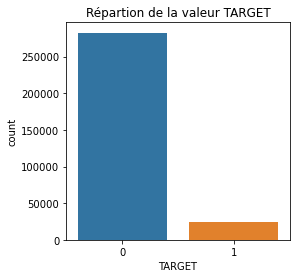

In [3]:
print(round(app_train.TARGET.value_counts(normalize = True),4)*100)
plt.rcParams["figure.figsize"] = (4, 4)
sns.countplot(data = app_train, x = "TARGET")
plt.title("Répartion de la valeur TARGET")

Le SMOTE, acronyme pour Synthetic Minority Oversampling TEchnique, est une méthode de suréchantillonnage des observations minoritaires. Le SMOTE se base sur un principe simple : générer de nouveaux individus minoritaires qui ressemblent aux autres, sans être strictement identiques. Cela permet de densifier de façon plus homogène la population d’individus minoritaires.<br>
Les règles de SMOTE :
- Optimiser les paramètres du SMOTE
- Normaliser les variables numériques avant le SMOTE
- Retraiter les variables discrètes après le SMOTE
- Ne jamais encoder les variables catégorielles en numériques 
- Ne jamais utiliser SMOTE sur les données validation/test

<br>
Le SMOTE est une technique très utile pour rééquilibrer les données numériques en entrée d’un modèle de Machine Learning. Il permet d’éviter le surapprentissage du modèle en densifiant les individus minoritaires de façon homogène et peut améliorer significativement les performances de vos modèles.

Pour utiliser le SMOTE sans danger, il est indispensable de se souvenir des cinq règles suivantes  :

- Les paramètres optimaux du SMOTE dépendent de vos données et doivent donc être optimisés. Le plus simple est de les optimiser en même temps que votre modèle.
- Les variables numériques doivent être normalisées.
- Les variables discrètes doivent être retraitées entre le SMOTE et le modèle.
- Les variables catégorielles doivent être conservées telles quelles et ne pas être encodées.
- Le SMOTE est réservé à l’entraînement du modèle et ne doit surtout pas être appliqué aux données de validation et de test.

<br>
Création des observations synthétiques
Pour créer un individu synthétique, les étapes définies dans l’algorithme du SMOTE sont les suivantes :

1. Sélectionner aléatoirement une observation minoritaire “initiale”.
2. Identifier ses k plus proches voisins parmi les observations minoritaires (où k est un paramètre défini par l’utilisateur).
3. Choisir aléatoirement l’un des k plus proches voisins.
4. Générer aléatoirement un coefficient 0 < a < 1
5. Créer un nouvel individu entre l’observation initiale et le plus proche voisin choisi, selon la valeur du coefficient . Par exemple, si a = 0.5, le nouvel individu sera positionné à mi-chemin entre l’observation initiale et le plus proche voisin choisi.

### Standardisation <a class="anchor" id="section_1_1"></a>

In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

col = app_test.select_dtypes(include = 'object').columns
cat_train = app_train.select_dtypes(include = 'object')
cat_test = app_test.select_dtypes(include = 'object')

cat_train = cat_train.apply(lambda col: le.fit_transform(col))
cat_test = cat_test.apply(lambda col: le.fit_transform(col))

cat_train.head(3)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,0,1,0,1,6,7,4,3,1,8,6,5,2,0,5,0
1,0,0,0,0,1,4,1,1,1,3,1,39,2,0,0,0
2,1,1,1,1,6,7,4,3,1,8,1,11,0,0,3,0


In [5]:
tab_train = app_train.copy()
tab_train[col] = cat_train
tab_train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_OUTLIERS
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False


In [6]:
tab_test = app_test.copy()
tab_test[col] = cat_test
tab_test.head(3)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_OUTLIERS
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,False
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,False


## SMOTE <a class="anchor" id="chapter2"></a>

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification, load_breast_cancer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler


X_train = tab_train.loc[ : , tab_train.columns != 'TARGET']
y_train = tab_train['TARGET'].values
X_test = tab_test

scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
data_train = pd.DataFrame(X_train_scaled)
data_train.columns = tab_test.columns
data_y_train = pd.DataFrame(y_train)
data_y_train.columns = ["TARGET"]

X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = tab_test.columns

Les données sont normalisée, on peut utiliser le SMOTE.

In [9]:
X = data_train.copy()
y = data_y_train.copy()

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)


pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000)]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print('Cross-validation score : %.3f' % cv_score)
print('Test score : %.3f' % test_score)
print('Meilleure paramètre : ', grid_search.best_params_)

Cross-validation score : 0.739
Test score : 0.734
Meilleure paramètre :  {'classifier__C': 1}


In [10]:
X = data_train.copy()
y = data_y_train.copy()

X_train_smote, X_test, y_train_smote, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)


pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000)]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {'classifier__C':[1]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print('Cross-validation score : %.3f' % cv_score)
print('Test score : %.3f' % test_score)

Cross-validation score : 0.739
Test score : 0.734


In [11]:
X_train_smote.shape, X_test.shape, y_train_smote.shape, y_test.shape

((246008, 122), (61503, 122), (246008, 1), (61503, 1))

#### DummyClassifier <a class="anchor" id="section_2_1"></a>

In [12]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
# create DummyClassifier model and generate predictions
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=0)
dummy_clf.fit(X_train_smote, y_train_smote)
y_pred = dummy_clf.predict(X_test)

In [13]:
def matrice_confusion(X_test, y_test, y_pred, model):
    from sklearn import metrics
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print('AUC : %0.4f' %roc_auc)
    print(classification_report(y_test, y_pred))

    y_pred = pd.DataFrame(y_pred)
    y_pred.columns = ["TARGET"]

    confusion_matrix = confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

    cm_display.plot()
    plt.show()

def score_cout(TN, FP, FN, TP):
    resultat = ((TP + TN) / (TP + TN + 10*FN + FP))
    return resultat

AUC : 0.5000
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



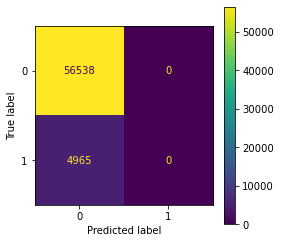

In [14]:
matrice_confusion(X_test,y_test, y_pred, dummy_clf)

In [15]:
TN = 56538
FP = 0
FN = 4965
TP = 0

resultat_dummy_clf = score_cout(TN, FP, FN, TP)
print("Le coût du modèle DummyClassifier est : %0.4f" %resultat_dummy_clf)

Le coût du modèle DummyClassifier est : 0.5324


#### RandomForest <a class="anchor" id="section_2_2"></a>

In [16]:
from sklearn.ensemble import RandomForestClassifier
# create random forest model and generate predictions
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train_smote, y_train_smote)
y_pred_smote = rfc.predict(X_test)

AUC : 0.7083
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.41      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.67      0.50      0.48     61503
weighted avg       0.88      0.92      0.88     61503



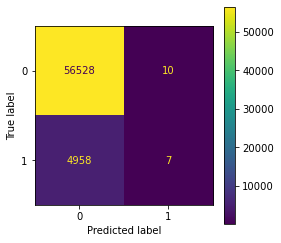

In [17]:
matrice_confusion(X_test, y_test, y_pred_smote, rfc)

In [18]:
TN = 56528
FP = 10
FN = 4958
TP = 7

resultat_rfc = score_cout(TN, FP, FN, TP)
print("Le coût du modèle RandomForestClassifier est : %0.4f" %resultat_rfc)

Le coût du modèle RandomForestClassifier est : 0.5327


#### LGBMClassifier <a class="anchor" id="section_2_3"></a>

In [19]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score
from collections import Counter
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

def cross_validation(x, y, model):
    result= cross_val_score(model, x, y, cv=kfold, scoring="roc_auc", n_jobs=-1)
    print("Score: %f" % result.mean())

lgb = LGBMClassifier()

scores = cross_validation(X_train_smote, y_train_smote, lgb)
lgb.fit(X_train_smote, y_train_smote)
y_pred_LGB = lgb.predict(X_test)
print(scores)

Score: 0.754699
None


AUC : 0.7530
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.56      0.02      0.03      4965

    accuracy                           0.92     61503
   macro avg       0.74      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503



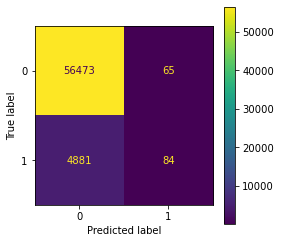

In [20]:
matrice_confusion(X_test, y_test, y_pred_LGB, lgb)

In [21]:
TN = 56473
FP = 65
FN = 4881
TP = 84
resultat_lgb = score_cout(TN, FP, FN, TP)
print("Le coût du modèle LGBMClassifier est : %0.4f" %resultat_lgb)

Le coût du modèle LGBMClassifier est : 0.5364


#### XGBClassifier <a class="anchor" id="section_2_4"></a>

In [22]:
from xgboost import XGBClassifier

xgbc = XGBClassifier()

scores_xgbc = cross_validation(X_train_smote, y_train_smote, xgbc)
xgbc.fit(X_train_smote, y_train_smote)
y_pred = xgbc.predict(X_test)
print(scores_xgbc)

Score: 0.748304
None


AUC : 0.7454
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.48      0.03      0.06      4965

    accuracy                           0.92     61503
   macro avg       0.70      0.51      0.51     61503
weighted avg       0.89      0.92      0.89     61503



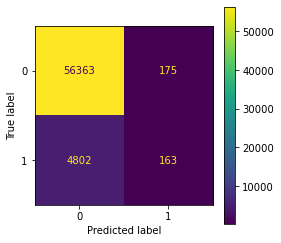

In [23]:
matrice_confusion(X_test, y_test, y_pred, xgbc)

In [24]:
TN = 56363
FP = 175
FN = 4802
TP = 163

resultat_xgbc = score_cout(TN, FP, FN, TP)
print("Le coût du modèle XGBClassifier est : %0.4f" %resultat_xgbc)

Le coût du modèle XGBClassifier est : 0.5398


#### AdaBoostClassifier <a class="anchor" id="section_2_5"></a>

In [25]:
ada = AdaBoostClassifier(learning_rate=0.2, 
                         algorithm = 'SAMME.R',
                         n_estimators=200, 
                         random_state=100)
scores_ada = cross_validation(X_train_smote, y_train_smote, ada)
ada.fit(X_train_smote, y_train_smote)
y_pred = ada.predict(X_test)
print(scores_ada)

Score: 0.749431
None


AUC : 0.7468
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.51      0.01      0.02      4965

    accuracy                           0.92     61503
   macro avg       0.71      0.50      0.49     61503
weighted avg       0.89      0.92      0.88     61503



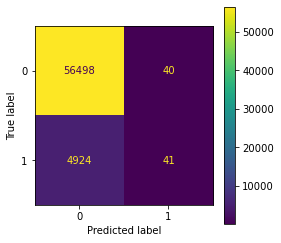

In [26]:
matrice_confusion(X_test, y_test, y_pred, ada)

In [27]:
TN = 56498
FP = 40
FN = 4924
TP = 41

resultat_ada = score_cout(TN, FP, FN, TP)
print("Le coût du modèle AdaBoostClassifier est : %0.4f" %resultat_ada)

Le coût du modèle AdaBoostClassifier est : 0.5343


Les meilleures résultats sont les derniers, mais on peut voir que le modèle le plus intéressant est LGBMClassifier

### ROC <a class="anchor" id="section_2_6"></a>

In [28]:
classifiers = [dummy_clf, rfc, lgb, xgbc, ada]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for cls in classifiers:
    model = cls.fit(X_train_smote, y_train_smote)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)

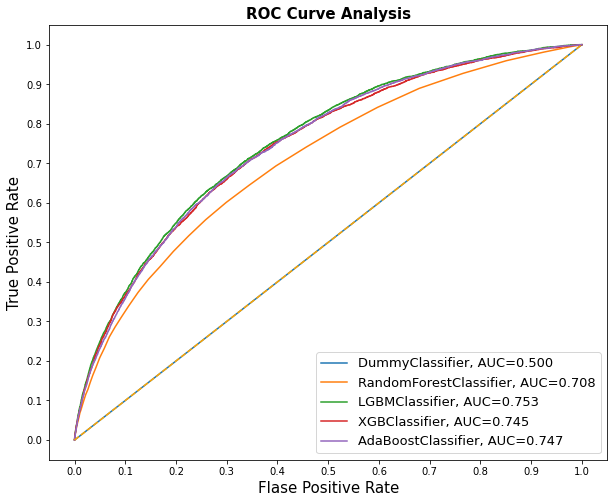

In [29]:
fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc'])
             )
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [30]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    AUC = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    Accuracy = accuracy_score(y_test, model.predict(X_test))
    Precision = precision_score(y_test, model.predict(X_test))
    Recall = recall_score(y_test, model.predict(X_test))
    F1 = f1_score(y_test, model.predict(X_test))

    score = [AUC, Accuracy, Precision, Recall, F1]
          
    return score

In [31]:
results = []
for model in classifiers:
    results.append(train_models(model, X_train_smote, X_test, y_train_smote, y_test))

Model = ["DummyClassifier", "RandomForestClassifier", "LGBMClassifier", "XGBClassifier", "AdaBoostClassifier"]
Model = pd.DataFrame(Model)
Model.columns = ["Model"]

results = pd.DataFrame(results)
results.columns = ["AUC", "Accuracy", "Precision", "Recall", "F1"]

On va fusionner les tableaux des erreurs et des précisions de chaque modèle.

In [32]:
cout = [resultat_dummy_clf, resultat_rfc, resultat_lgb, resultat_xgbc, resultat_ada]
Cout = pd.DataFrame(cout)
Cout.columns = ["Cout"]
Cout = Model.join(Cout, how = 'outer')

score = Model.join(results, how = 'outer')
score = pd.merge(score, Cout, on = "Model", how = 'outer')
score.sort_values('AUC', ascending=False, inplace=True)
score

,Model,AUC,Accuracy,Precision,Recall,F1,Cout
2,LGBMClassifier,0.752987,0.919581,0.563758,0.016918,0.032851,0.536431
4,AdaBoostClassifier,0.746830,0.919288,0.506173,0.008258,0.016250,0.534299
3,XGBClassifier,0.745422,0.919077,0.482249,0.032830,0.061475,0.539777
1,RandomForestClassifier,0.708336,0.919223,0.411765,0.001410,0.002810,0.532721
0,DummyClassifier,0.500000,0.919272,0.000000,0.000000,0.000000,0.532433


## Class weight <a class="anchor" id="chapter3"></a>

(246008, 122) (246008, 1)
Accuracy score on balanced weights: 70.3%
F1 score on balanced weights: 0.267
AUC : 0.7575
              precision    recall  f1-score   support

           0       0.92      0.68      0.78     56554
           1       0.08      0.32      0.13      4949

    accuracy                           0.65     61503
   macro avg       0.50      0.50      0.46     61503
weighted avg       0.85      0.65      0.73     61503



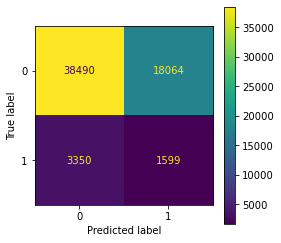

In [33]:
X = data_train.copy()
y = data_y_train.copy()

X_train_weight, X_test_weight, y_train_weight, y_test_weight = train_test_split(X,
                                 y,test_size=0.2,random_state=42)
print(X_train_weight.shape,y_train_weight.shape)

lgbm_classifier = LGBMClassifier(class_weight='balanced')
lgbm_classifier.fit(X_train_weight, y_train_weight)
print(f'Accuracy score on balanced weights: {lgbm_classifier.score(X_test_weight, y_test_weight)*100:.1f}%')
print(f'F1 score on balanced weights: {f1_score(y_test_weight,lgbm_classifier.predict(X_test_weight)):.3f}')
y_pred_weight = lgbm_classifier.predict(X_test)
matrice_confusion(X_test_weight, y_test_weight, y_pred_weight, lgbm_classifier)

In [34]:
TN = 39900
FP = 16654
FN = 1614
TP = 3335

resultat_lgb_weight = score_cout(TN, FP, FN, TP)
print("Le cout du modèle de LGBMClassifier avec la méthode de Class Weight est %0.4f" %resultat_lgb_weight)

Le cout du modèle de LGBMClassifier avec la méthode de Class Weight est 0.5687


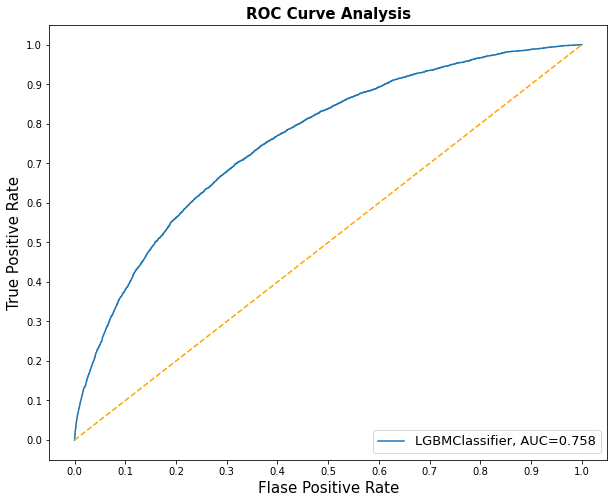

In [35]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

classifiers = [lgbm_classifier]

for cls in classifiers:
    model = cls.fit(X_train_weight, y_train_weight)
    yproba = model.predict_proba(X_test_weight)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test_weight, yproba)
    auc = roc_auc_score(y_test_weight, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc'])
             )
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [36]:
results_weight = []
classifiers = [lgbm_classifier]
for model in classifiers:
    results_weight.append(train_models(model, X_train_weight, X_test_weight, y_train_weight, y_test_weight))

Model = ["LGBMClassifier_Class_Weight"]
Model = pd.DataFrame(Model)
Model.columns = ["Model"]

results_weight = pd.DataFrame(results_weight)
results_weight.columns = ["AUC", "Accuracy", "Precision", "Recall", "F1"]

In [37]:
cout = [resultat_lgb_weight]
Cout = pd.DataFrame(cout)
Cout.columns = ["Cout"]
Cout = Model.join(Cout, how = 'outer')

score_weight = Model.join(results_weight, how = 'outer')
score_weight = pd.merge(score_weight, Cout, on = "Model", how = 'outer')
score = score.append(score_weight)
score.sort_values('AUC', ascending=False, inplace=True)
score

,Model,AUC,Accuracy,Precision,Recall,F1,Cout
0,LGBMClassifier_Class_Weight,0.757537,0.702974,0.166842,0.673874,0.267463,0.568665
2,LGBMClassifier,0.752987,0.919581,0.563758,0.016918,0.032851,0.536431
4,AdaBoostClassifier,0.746830,0.919288,0.506173,0.008258,0.016250,0.534299
3,XGBClassifier,0.745422,0.919077,0.482249,0.032830,0.061475,0.539777
1,RandomForestClassifier,0.708336,0.919223,0.411765,0.001410,0.002810,0.532721
0,DummyClassifier,0.500000,0.919272,0.000000,0.000000,0.000000,0.532433


## Sélection du modèle <a class="anchor" id="chapter4"></a>

On choisit le modèle LGBMClassifier, on va modifier les paramètres pour prendre les meilleures.

In [38]:
lgb = LGBMClassifier()

scores = cross_validation(X_train_smote, y_train_smote, lgb)
lgb.fit(X_train_smote, y_train_smote)

score = model.score(X_test, y_test)
print("Le score est : %0.4f" %score)

y_pred_scaled = lgb.predict(X_test_scaled)

Score: 0.754699
Le score est : 0.7128


In [39]:
print("LGBMClassifier :")
note_0 = ((y_pred_scaled == 0).sum()*100/y_pred_scaled.shape[0])
print('- TARGET[0] : %.3f' % note_0, '%')
nb_0 = (y_pred_scaled == 0).sum()
print('- TARGET[0] :', nb_0)
note_1 = ((y_pred_scaled == 1).sum()*100/y_pred_scaled.shape[0])
print('- TARGET[1] : %.3f' % note_1, '%')
nb_1 = (y_pred_scaled == 1).sum()
print('- TARGET[1] :', nb_1)

LGBMClassifier :
- TARGET[0] : 99.877 %
- TARGET[0] : 48684
- TARGET[1] : 0.123 %
- TARGET[1] : 60


## Les features les plus importantes <a class="anchor" id="chapter5"></a>

### Les Features les plus importantes de manière globales <a class="anchor" id="section_5_1"></a>

On va regarder les valeurs les plus importantes. Ces codes vont se retrouvé sur le FASTAPI et Streamlit.

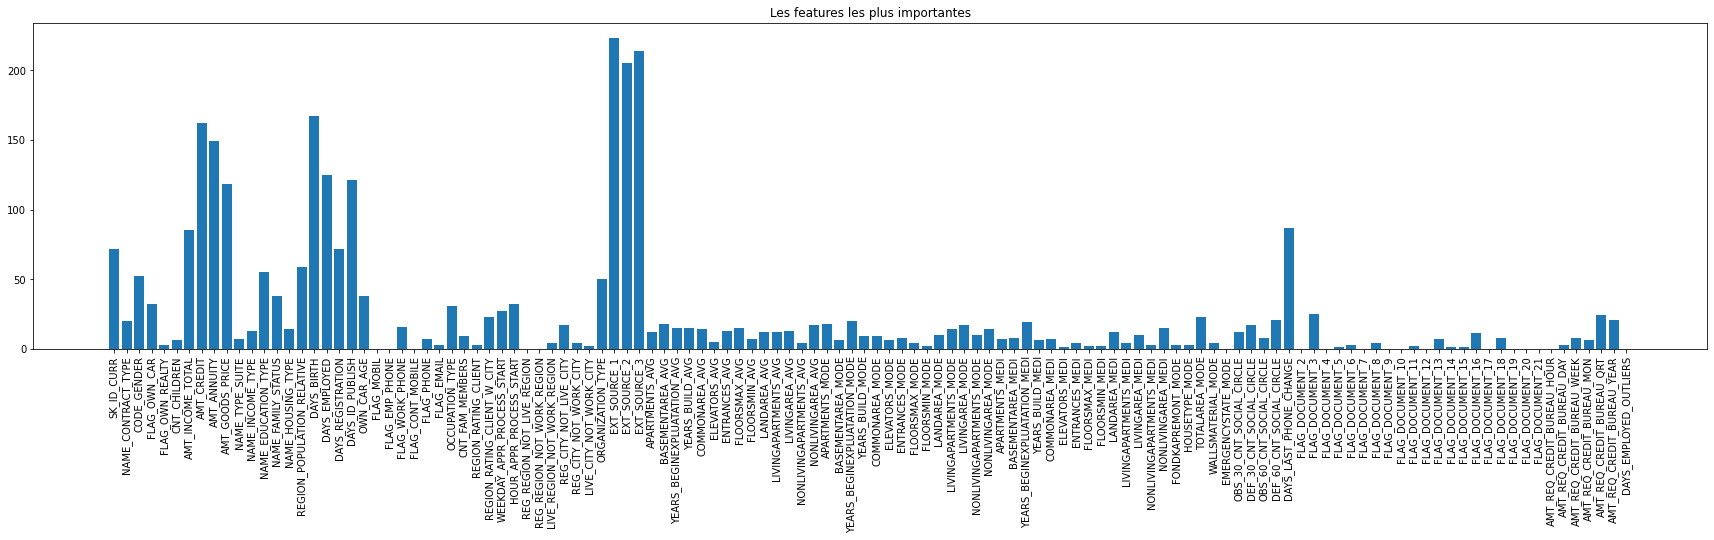

In [40]:
# LGBMClassifier for feature importance on a classification problem
from sklearn.datasets import make_classification
# get importance
importance = lgb.feature_importances_
# plot feature importance
plt.rcParams["figure.figsize"] = (30, 6)
plt.bar([x for x in range(len(importance))], importance, tick_label = X_train.columns)
plt.xticks(rotation=90)
plt.title("Les features les plus importantes")
plt.show()

In [41]:
# summarize feature importance
col = X_train.columns
col_imp = []
for i,v in enumerate(importance):
	if v >= 100 :
		print('Colonne : %s, Score : %.5f' % (col[i],v))

Colonne : AMT_CREDIT, Score : 162.00000
Colonne : AMT_ANNUITY, Score : 149.00000
Colonne : AMT_GOODS_PRICE, Score : 118.00000
Colonne : DAYS_BIRTH, Score : 167.00000
Colonne : DAYS_EMPLOYED, Score : 125.00000
Colonne : DAYS_ID_PUBLISH, Score : 121.00000
Colonne : EXT_SOURCE_1, Score : 223.00000
Colonne : EXT_SOURCE_2, Score : 205.00000
Colonne : EXT_SOURCE_3, Score : 214.00000


In [42]:
importance = importance[importance >= 100]
col_imp = ["AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE",
           "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_ID_PUBLISH",
           "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
tab = pd.DataFrame(importance)
tab = tab.transpose()
tab.rename(columns=lambda x, y=iter(col_imp): next(y), inplace = True)

Text(0.5, 1.0, 'Les features les plus importantes')

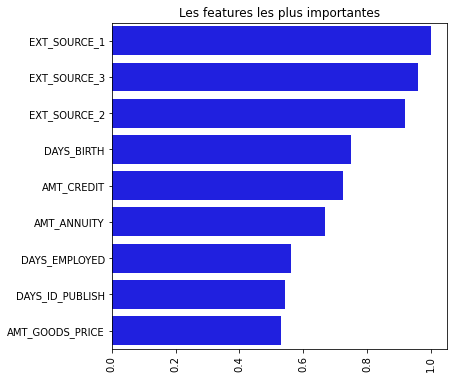

In [43]:
tab = tab.transpose().sort_values(by=0, ascending = False)

for column in tab.columns:
    tab[column] = tab[column]  / tab[column].abs().max()

plt.rcParams["figure.figsize"] = (6, 6)
sns.barplot(data=tab.transpose(), color = 'blue', orient='h')
plt.xticks(rotation=90)
plt.title("Les features les plus importantes")

### Les Features les plus importantes de manières locales <a class="anchor" id="section_5_2"></a>

In [44]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
        training_data=np.array(X_train_smote),
        feature_names=X_train_smote.columns,
        class_names=['Positif', 'Negatif'],
        mode='classification'
)

In [45]:
plt.rcParams["figure.figsize"] = (30, 30)

exp = explainer.explain_instance(
    data_row = X_test_scaled.iloc[212], 
    predict_fn = lgb.predict_proba
)

exp.show_in_notebook(show_table=True)

Les features importantes qui fait que ce client n'est pas à risque et peut rembourser son prêts.

In [46]:
exp.as_list()

[('EXT_SOURCE_2 <= -0.64', 0.044553892911985755),
 ('FLAG_DOCUMENT_20 <= -0.02', -0.039519655828418834),
 ('FLAG_DOCUMENT_9 <= -0.06', -0.027060415835758966),
 ('FLAG_DOCUMENT_21 <= -0.02', 0.023231502821898186),
 ('FLAG_DOCUMENT_15 <= -0.03', 0.019989132663103207),
 ('AMT_GOODS_PRICE > 0.38', -0.019321886076123194),
 ('EXT_SOURCE_1 > 0.01', -0.018711318386929063),
 ('FLAG_DOCUMENT_13 <= -0.06', 0.016764926759959158),
 ('FLAG_DOCUMENT_7 <= -0.01', 0.014600412929672475),
 ('FLAG_DOCUMENT_19 <= -0.02', -0.011599696755103243)]

In [47]:
test = pd.DataFrame(y_pred_scaled)
test.columns = ["TARGET"]
test[test["TARGET"] == 1].T

,2477,2764,2979,3089,3100,3640,5604,6747,7311,7670,...,41203,41324,41338,43607,44283,44795,44958,46343,46351,47988
TARGET,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [48]:
plt.rcParams["figure.figsize"] = (30, 30)

exp = explainer.explain_instance(
    data_row = X_test_scaled.iloc[2764], 
    predict_fn = lgb.predict_proba
)

exp.show_in_notebook(show_table=True)

Les features importantes qui fait que ce client est à risque et ne peut pas rembourser son prêts. Donc il peut voir qu'elles features fait défaut.

In [49]:
exp.as_list()

[('FLAG_DOCUMENT_20 <= -0.02', -0.05070181251354744),
 ('EXT_SOURCE_3 <= -0.57', 0.04898060493303323),
 ('EXT_SOURCE_2 <= -0.64', 0.04368381958011282),
 ('FLAG_DOCUMENT_21 <= -0.02', 0.020067145395248672),
 ('EXT_SOURCE_1 > 0.01', -0.017424440704986395),
 ('NAME_FAMILY_STATUS <= -0.40', -0.015396656338230412),
 ('DEF_30_CNT_SOCIAL_CIRCLE <= -0.32', -0.015006974960537042),
 ('AMT_REQ_CREDIT_BUREAU_QRT <= -0.31', -0.014235695680234849),
 ('OWN_CAR_AGE <= -0.15', -0.01141012856924856),
 ('FLAG_DOCUMENT_19 <= -0.02', 0.00029222610407270345)]

## API <a class="anchor" id="chapter6"></a>

Ici, on va enregistrer les données pour pouvoir les mettre sur FAST API et Streamlit. On va enregistrer des DataFrame en réduisant la taille pour éviter un temps de chargement important.<br>
Pour afficher en local pour FASTAPI, il faut taper cette commande :<br>
uvicorn main:app --reload<br>
Pour afficher streamlit en local, il faut taper cette commande :<br>
streamlit run dashboard.py

In [50]:
import joblib
joblib.dump(lgb, 'FastAPI/lgb_credit.joblib')

from mlflow.models.signature import infer_signature
signature = infer_signature(X_train_smote, y_train_smote)

import mlflow.sklearn

mlflow.sklearn.save_model(lgb, 'FastAPI/mlflow_model', signature=signature)

Séparation du fichier pôur diminuer la taille, on va prendre autant de client en diffuculté ou pas.

In [51]:
# On va garder les identifiants clients non normalisé pour faciliter le code
X_test_scaled["SK_ID_CURR"] = tab_test["SK_ID_CURR"]

# On sépare le tableau en deux, pour contruire deux fichier avec autant de client en difficulté et en non difficultés
val_1 = X_test_scaled.iloc[test[test["TARGET"] == 1].index]

val_0 = X_test_scaled.iloc[test[test["TARGET"] == 0].index]
val_0 = val_0.iloc[0:60, :]

# On fusionne les tableaux et on affiche le résultat
X_test_scaled = val_0.append(val_1)

In [52]:
test = tab_test
test = test[test['SK_ID_CURR'].isin(X_test_scaled['SK_ID_CURR'].values)]

In [53]:
# On sauvegarde ce tableau dans le dossier data
X_test_scaled.to_csv("data/X_test_scaled.csv", index=False)
X_train_smote.to_csv("data/X_train_scaled.csv", index=False)
test.to_csv("data/X_test.csv", index=False)